# Plot results

## Setup

In [1]:
# seaborn is not installed in notebook Docker image
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)


In [42]:
from os.path import join
import io

import s3fs
import pandas as pd
import seaborn as sns

In [44]:
# Code adapted from https://stackoverflow.com/questions/63724324/saving-matplotlib-image-to-s3-bucket-from-ec2-instance
def savefig_s3(fig, out_uri, **extra_args):
    img_data = io.BytesIO()
    fig.savefig(img_data, **extra_args)
    img_data.seek(0)
    s3 = s3fs.S3FileSystem()
    with s3.open(out_uri, 'wb') as f:
        f.write(img_data.getbuffer())

In [50]:
def add_extra_cols(df):
    # Add chunk_sz string column for convenience.
    df['chunk_sz'] = [f'({x}, {y})' for x, y in zip(df.time_chunk_sz.values, df.feature_id_chunk_sz.values)]

    # Add human readable column names for plotting purposes. It would be nice if we didn't have to do this, and could 
    # just tell the plotting function how to translate column names.
    df['chunk shape'] = df['chunk_sz']
    df['run time: secs'] = df['time']
    df['days in query'] = df['nb_days']
    return df

In [51]:
out_root_uri = 's3://azavea-noaa-hydro-data/esip-experiments/plots/zarr/lf/07-16-2022a/'

# Read in results generated by benchmark_queries.ipynb.
results_uri = 's3://azavea-noaa-hydro-data/esip-experiments/benchmarks/zarr/lf/07-16-2022a.csv'
zarr_df = add_extra_cols(pd.read_csv(results_uri))
zarr_df.head()

,Unnamed: 0,query,time,nb_reaches,nb_days,data_format,time_chunk_sz,feature_id_chunk_sz,nb_workers,repeat_ind,chunk_sz,chunk shape,run time: secs,days in query
0,0,mean_features_mean_day,25.575601,1787,3652,zarr,672,30000,16,0,"(672, 30000)","(672, 30000)",25.575601,3652
1,1,mean_features_mean_day,24.883382,1787,3652,zarr,672,30000,16,1,"(672, 30000)","(672, 30000)",24.883382,3652
2,2,mean_features_mean_day,24.268302,1787,3652,zarr,672,30000,16,2,"(672, 30000)","(672, 30000)",24.268302,3652
3,3,mean_features_mean_day,23.722426,1787,3652,zarr,672,30000,16,3,"(672, 30000)","(672, 30000)",23.722426,3652
4,4,mean_features_mean_day,24.381311,1787,3652,zarr,672,30000,16,4,"(672, 30000)","(672, 30000)",24.381311,3652


In [54]:
parquet_uri = 's3://azavea-noaa-hydro-data/esip-experiments/benchmarks/parquet/lf/07-16-2022a.csv'
parquet_df = add_extra_cols(pd.read_csv(parquet_uri))
parquet_df.head()

,Unnamed: 0,query,time,nb_reaches,nb_days,data_format,time_chunk_sz,feature_id_chunk_sz,repeat_ind,chunk_sz,chunk shape,run time: secs,days in query
0,0,mean_day,97.748487,1787,3652,parquet,-9999,-9999,0,"(-9999, -9999)","(-9999, -9999)",97.748487,3652
1,1,mean_day,92.344385,1787,3652,parquet,-9999,-9999,1,"(-9999, -9999)","(-9999, -9999)",92.344385,3652
2,2,mean_day,90.418753,1787,3652,parquet,-9999,-9999,2,"(-9999, -9999)","(-9999, -9999)",90.418753,3652
3,3,mean_day,88.971510,1787,3652,parquet,-9999,-9999,3,"(-9999, -9999)","(-9999, -9999)",88.971510,3652
4,4,mean_day,88.007001,1787,3652,parquet,-9999,-9999,4,"(-9999, -9999)","(-9999, -9999)",88.007001,3652


## Plot using `seaborn`

### Make bar plot that is a visual dump of the whole dataframe.

Plotting concepts:
* things you can control in plot: x, y, hue, row, col, 
* independent vars: query, nb_days, chunk_sz
* (other independent vars we aren't varying yet): data_format, nb_reaches, nb_workers
* dependent vars: time_mean, time_std

Observations:
* The transposed chunk size (30000, 672) is much faster for large queries over 3652 days, but doesn't have much of an effect for smaller queries.
* The different queries all take roughly the same amount of time.

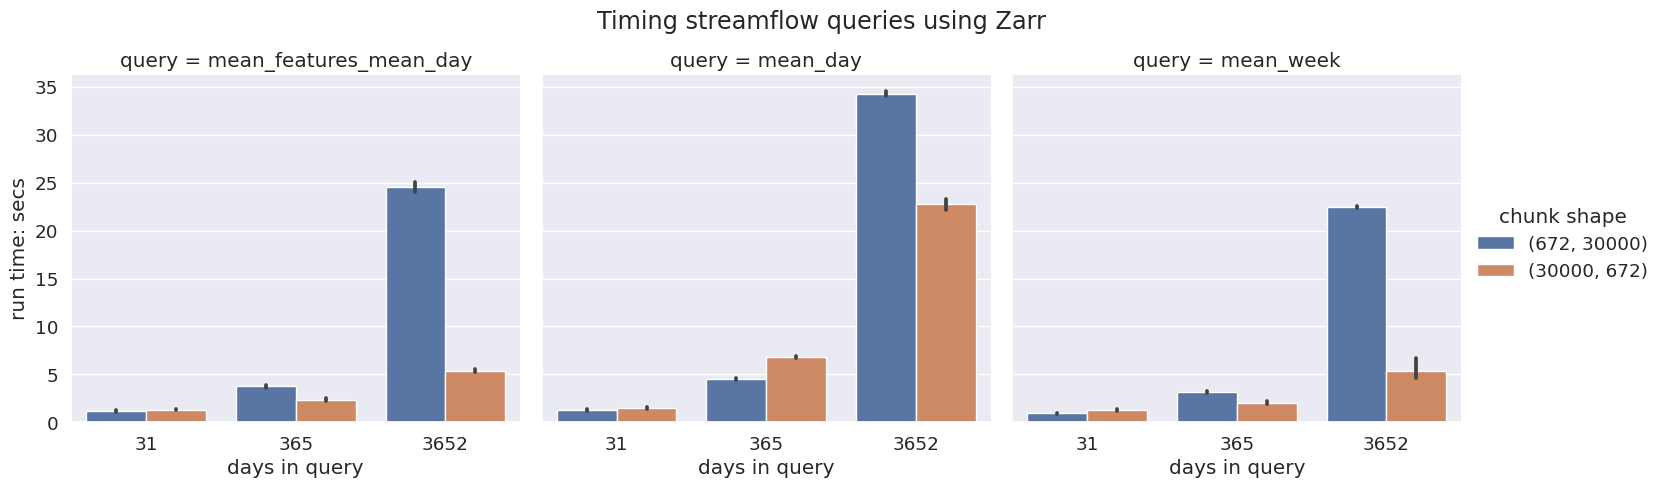

In [52]:
# Zarr
sns.set(font_scale = 1.2)
plot = sns.catplot(
    x='days in query', y='run time: secs', col='query', hue='chunk shape', 
    kind='bar', data=zarr_df)
fig = plot.fig
fig.subplots_adjust(top=0.85)
fig.suptitle('Timing streamflow queries using Zarr')
savefig_s3(fig, join(out_root_uri, 'zarr.png'), format='png', dpi=200)

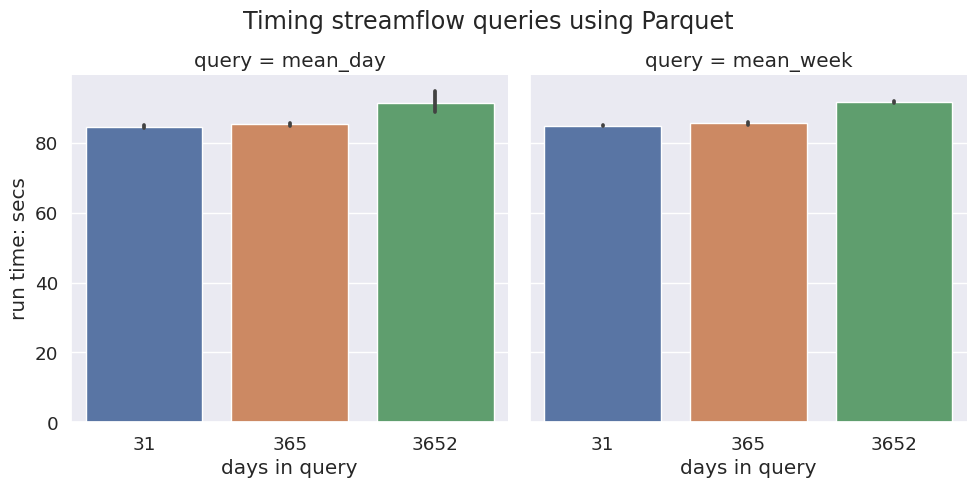

In [55]:
# Parquet
plot = sns.catplot(
    x='days in query', y='run time: secs', col='query',
    kind='bar', data=parquet_df)
fig = plot.fig
fig.subplots_adjust(top=0.85)
fig.suptitle('Timing streamflow queries using Parquet')
savefig_s3(fig, join(out_root_uri, 'parquet.png'), format='png', dpi=200)

### Make a plot of one query comparing Zarr and Parquet

In [56]:
df = pd.concat([parquet_df.query('query == "mean_day"'), zarr_df.query('query == "mean_day"')])

data_format = []
for _data_format, _chunk_shape in zip(df.data_format.values, df['chunk shape'].values):
    if _data_format == 'zarr':
        data_format.append(f'zarr {_chunk_shape}')
    else:
        data_format.append('parquet')
        
df['data format'] = data_format

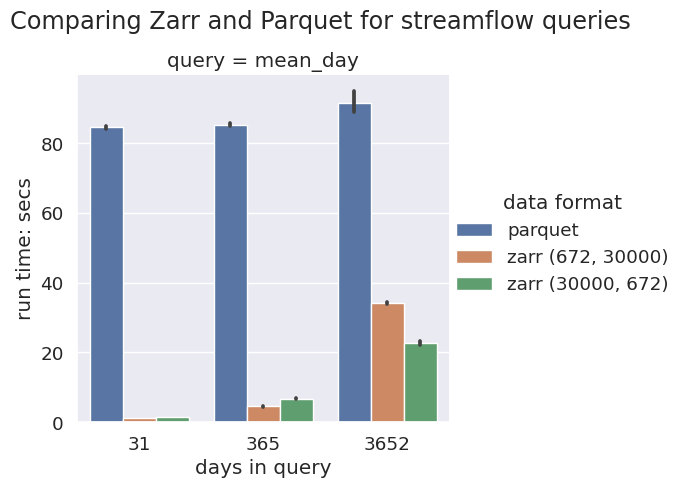

In [57]:
plot = sns.catplot(
    x='days in query', y='run time: secs', col='query', hue='data format',
    kind='bar', data=df)
fig = plot.fig
fig.subplots_adjust(top=0.85)
fig.suptitle('Comparing Zarr and Parquet for streamflow queries')
savefig_s3(fig, join(out_root_uri, 'compare.png'), format='png', dpi=200)

## Plot using `pandas`

(This isn't as good as using seaborn, but is here just in case).

In [66]:
# This groups by chunk size over all experiments to see the effect of this indpendent variable.
_df = df.groupby('chunk_sz', as_index=False).mean()
_df

,chunk_sz,Unnamed: 0,time_mean,time_std,nb_reaches,nb_days,nb_repeats,time_chunk_sz,feature_id_chunk_sz
0,"(30000, 672)",13.0,5.87690,0.162814,1787.0,1349.333333,5.0,30000.0,672.0
1,"(672, 30000)",4.0,10.37084,0.552675,1787.0,1349.333333,5.0,672.0,30000.0


<AxesSubplot:xlabel='chunk_sz'>

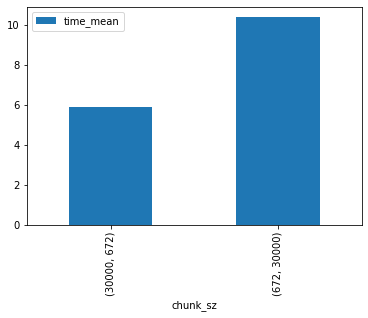

In [67]:
_df.plot('chunk_sz', 'time_mean', 'bar')